# **Assignment 5: Synthetic Data Generation using Variational Autoencoder**

Submitted By:

1. Anadi Gautam **EM23MTECH14003**
2. Chetan sai pyla **EM23MTECH11001**
3. Dharmendra Singh Yadav **EM23MTECH11002**
4. Jay Patel **EM23MTECH11003**
5. Krishna Kumar **EM23MTECH11006**

# Import the dataset

In [ ]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Lambda
from tensorflow.keras import Model, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
column_names=['user', 'card', 'year', 'month', 'day', 'time', 'amount', 'chip', 'merchant_name', 'merchant_city', 'merchant_state', 'zip_code', 'mcc', 'errors', 'fraud']

df = pd.read_csv('/content/drive/My Drive/card_transaction.v1.csv',
        sep=',',
        header='infer',
        names=column_names,
        skiprows=1)

# Perform Preprocessing of dataset

In [ ]:
def fill_na_values(df):
    fill_values = {'merchant_state': 'new_state', 'zip_code': 00000, 'chip': 'new_chip', 'errors': 'new_errors'}
    df.fillna(value=fill_values, inplace=True)
    return df

def drop_na_values(df):
    columns = ['mcc', 'fraud', 'merchant_city', 'merchant_name', 'chip', 'amount']
    df.dropna(subset=columns, inplace=True)
    return df

def drop_duplicates(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def encode_labels(df):
    label_encoders = {
        'merchant_state': LabelEncoder(),
        'merchant_city': LabelEncoder(),
        'zip_code': LabelEncoder(),
        'chip': LabelEncoder(),
        'errors': LabelEncoder(),
        'fraud': LabelEncoder()
    }
    for column, encoder in label_encoders.items():
        df[column] = encoder.fit_transform(df[column])
    return df

def convert_data(df):
    return (
        df.assign(
            amount=lambda x: x['amount'].str.replace('$', '').astype(float),
            hour=lambda x: x['time'].str[0:2].astype(float),
            minute=lambda x: x['time'].str[3:5].astype(float)
        )
        .drop(columns=['time'])
    )

def preprocess_data_credit_card_v1(df):
    df = fill_na_values(df)
    df = drop_na_values(df)
    df = drop_duplicates(df)
    df = encode_labels(df)
    df = convert_data(df)
    return df

# Define preprocessing steps
preprocessing_steps = [
    ('cleaning', FunctionTransformer(preprocess_data_credit_card_v1, validate=False))
]

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=preprocessing_steps, verbose=True)

# Fit and transform the data using the preprocessing pipeline
df = preprocessing_pipeline.fit_transform(df)


[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  12.7s


# Perform Exploratory Dataset Analysis

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Filter the DataFrame for fraud cases
fraud_cases = df[df['fraud'] == 1]

# Exclude certain columns from categorical identification
excluded_columns = ['amount', 'fraud', 'merchant_name', 'merchant_city', 'zip_code', 'errors']
included_columns = [column for column in fraud_cases.columns if column not in excluded_columns]

# Identify categorical columns
categorical_columns = set(included_columns)

# Define subplot grid dimensions
columns_per_row = 2
rows = (len(categorical_columns) + 1) // columns_per_row

# Create subplots
fig = make_subplots(rows=rows, cols=columns_per_row, subplot_titles=list(categorical_columns))

# Plot KDE for each categorical column using plotly
for idx, column in enumerate(categorical_columns):
    row = idx // columns_per_row + 1
    col = idx % columns_per_row + 1
    fig.add_trace(
        go.Histogram(x=fraud_cases[column], histnorm='probability density', name=column),
        row=row, col=col
    )

# Update layout and display plot
fig.update_layout(title="KDE Plots for Categorical Columns", showlegend=False)
fig.update_xaxes(title_text="Value")
fig.update_yaxes(title_text="Density")
fig.show()


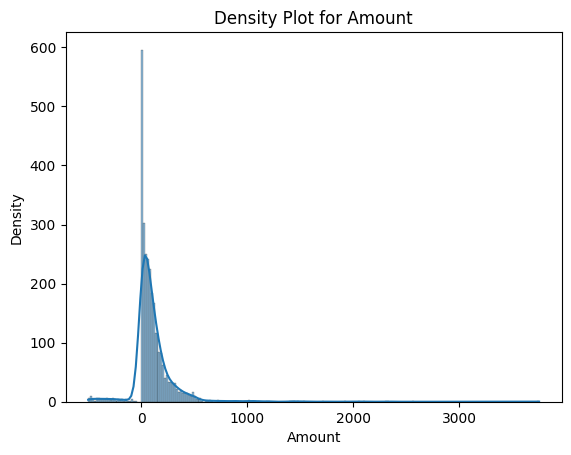

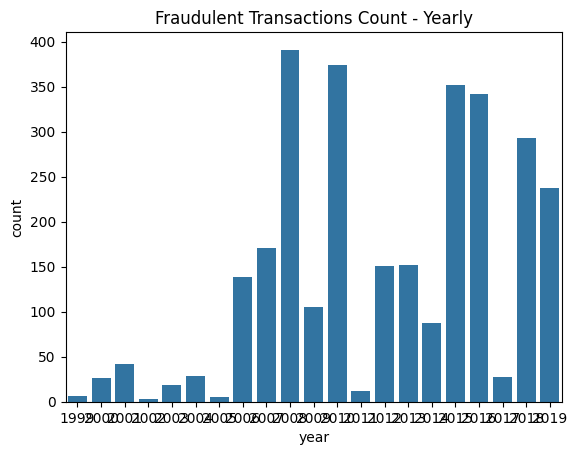

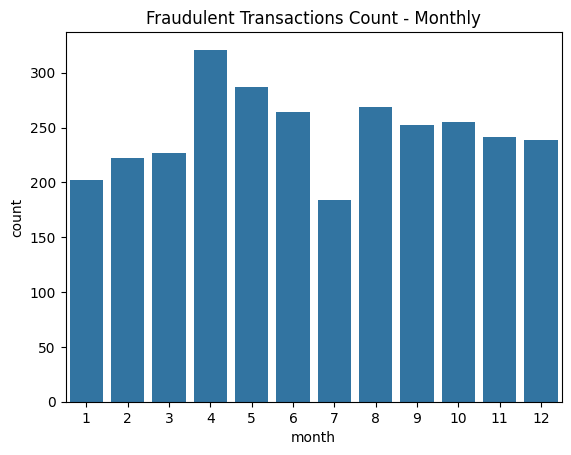

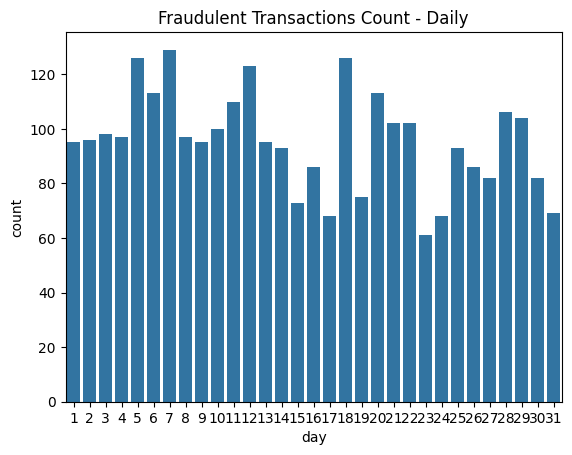

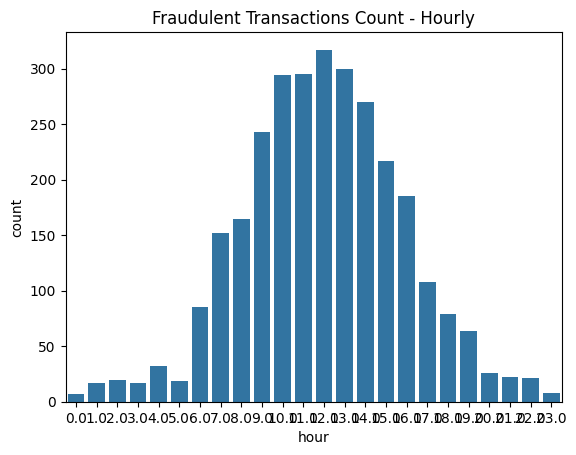

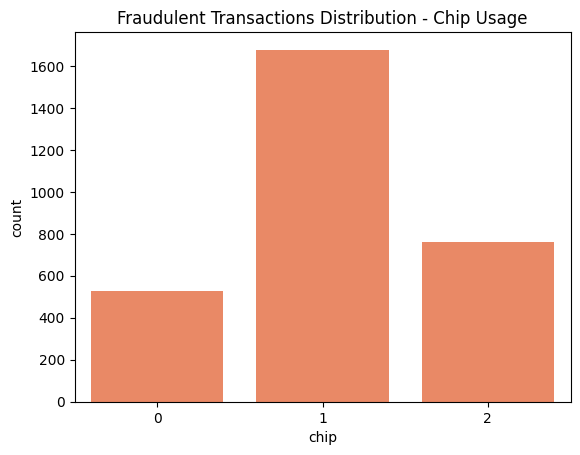

In [ ]:



# Plot density plot for amount in fraud cases
sns.histplot(
    data=fraud_cases,
    x='amount',
    kde=True,
    fill=True
)
plt.xlabel('Amount')
plt.ylabel('Density')
plt.title('Density Plot for Amount')
plt.show()

# Plot count of fraudulent transactions yearly
sns.countplot(
    data=fraud_cases,
    x='year'
)
plt.title('Fraudulent Transactions Count - Yearly')
plt.show()


# Fraudulent Transactions Count - Monthly
sns.countplot(data=fraud_cases, x='month')
plt.title('Fraudulent Transactions Count - Monthly')
plt.show()

# Plot count of fraudulent transactions daily
sns.countplot(
    data=fraud_cases,
    x='day'
)
plt.title('Fraudulent Transactions Count - Daily')
plt.show()

# Plot count of fraudulent transactions hourly
sns.countplot(
    data=fraud_cases,
    x='hour',
    order=sorted(fraud_cases['hour'].unique())
)
plt.title('Fraudulent Transactions Count - Hourly')
plt.show()

# Plot distribution of chip usage in fraudulent transactions
sns.countplot(
    data=fraud_cases,
    x='chip',
    color='coral'
)
plt.title('Fraudulent Transactions Distribution - Chip Usage')
plt.show()



# Generate training and testing dataset

In [ ]:
# Divide the dataset into non-fraudulent and fraudulent transactions
fraudulent_transactions = df[df['fraud'] == 1]
non_fraudulent_transactions = df[df['fraud'] == 0]

# Display the size of each subset
print(f'Non-fraudulent transactions: {non_fraudulent_transactions.shape[0]} rows, {non_fraudulent_transactions.shape[1]} columns')
print(f'Fraudulent transactions: {fraudulent_transactions.shape[0]} rows, {fraudulent_transactions.shape[1]} columns')
print('\n', '-'*100, '\n')

# Display the percentage of each type of transaction
print(f'Non-fraudulent transactions: {non_fraudulent_transactions.shape[0] / df.shape[0] * 100:.2f}%')
print(f'Fraudulent transactions: {fraudulent_transactions.shape[0] / df.shape[0] * 100:.2f}%')
print('\n', '-'*100, '\n')

# Split the non-fraudulent data into training and remaining subsets
training_data = non_fraudulent_transactions.sample(frac=0.66, random_state=42)
remaining_data = non_fraudulent_transactions.drop(training_data.index)

# Combine the remaining non-fraudulent data with the fraudulent data
combined_data = pd.concat([remaining_data, fraudulent_transactions])
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the size of the combined data
print(f'Combined data: {combined_data.shape[0]} rows, {combined_data.shape[1]} columns')
print('\n', '-'*100, '\n')

# Display the percentage of each type of transaction in the combined data
print(f'Non-fraudulent transactions in combined data: {remaining_data.shape[0] / combined_data.shape[0] * 100:.2f}%')
print(f'Fraudulent transactions in combined data: {fraudulent_transactions.shape[0] / combined_data.shape[0] * 100:.2f}%')
print('\n', '-'*100, '\n')

# Split the data into features and target variable for training and testing
X_train, y_train = training_data.drop(columns='fraud'), training_data['fraud']
X_test, y_test = combined_data.drop(columns='fraud'), combined_data['fraud']

# Use non-fraudulent transactions for further analysis
non_fraudulent_transactions = X_train.copy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print the shapes of the scaled datasets
print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled test data:", X_test_scaled.shape)

Non-fraudulent transactions: 2552219 rows, 16 columns
Fraudulent transactions: 2963 rows, 16 columns

 ---------------------------------------------------------------------------------------------------- 

Non-fraudulent transactions: 99.88%
Fraudulent transactions: 0.12%

 ---------------------------------------------------------------------------------------------------- 

Combined data: 870717 rows, 16 columns

 ---------------------------------------------------------------------------------------------------- 

Non-fraudulent transactions in combined data: 99.66%
Fraudulent transactions in combined data: 0.34%

 ---------------------------------------------------------------------------------------------------- 

Shape of scaled training data: (1684465, 15)
Shape of scaled test data: (870717, 15)


# Variational Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Autoencoder model
def autoencoder(input_dim, latent_dim):
    encoder = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.LeakyReLU(0.01),
        nn.Linear(32, 16),
        nn.ReLU()
    )

    decoder = nn.Sequential(
        nn.Linear(latent_dim, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.LeakyReLU(0.01),
        nn.Linear(32, input_dim),
        nn.ELU()
    )

    return encoder, decoder

# Instantiate the encoder and decoder
input_dim = X_train.shape[1]
latent_dim = 8
encoder, decoder = autoencoder(input_dim, latent_dim)

# Define loss function
reconstruction_loss_fn = nn.MSELoss()

# Define optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Create PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Training loop
for epoch in range(32):
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        z = encoder(inputs)
        outputs = decoder(z)
        reconstruction_loss = reconstruction_loss_fn(outputs, targets)
        loss = reconstruction_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss}")

# Save the models
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 8),                  1312      ['input_5[0][0]']             
                              (None, 8),                                                          
                              (None, 8)]                                                          
                                                                                                  
 decoder (Functional)        (None, 15)                   1183      ['encoder[0][2]']             
                                                                                                

OSError: No file or directory found at autoencoder.h5

# Observing trained model

In [ ]:
from sklearn.metrics import mean_squared_error

# Function to calculate mean squared error
def calculate_mse(model, true_data):
    reconstructed_data = model.predict(true_data)
    return mean_squared_error(true_data, reconstructed_data)

# Evaluate the model on test data
def evaluate_model(model, X_test, y_test):
    mse_total = calculate_mse(model, X_test)

    non_fraud_data = X_test[y_test == 0]
    fraud_data = X_test[y_test == 1]

    mse_non_fraud = calculate_mse(model, non_fraud_data)
    mse_fraud = calculate_mse(model, fraud_data)

    return mse_total, mse_non_fraud, mse_fraud, non_fraud_data, fraud_data

# Perform model evaluation
mse_total, mse_non_fraud, mse_fraud, non_fraud_data, fraud_data = evaluate_model(autoencoder, X_test, y_test)


# Generate the Syntehetic data points

In [ ]:
# Sample non-fraudulent points from the distributions generated

# Extract the values of the mean and log variances
means, log_variances = autoencoder.get_weights()[4], autoencoder.get_weights()[5]
variances = np.exp(log_variances * 1e5)

# Scale the values of means and variances adjusted according to the given feature statistical metrics
scaled_means = means * 1e6
scaled_variances = variances * 1e1

# Define the number of synthetic points to generate
num_points = 200000

synthetic_data_samples = np.empty((num_points, X_train.shape[1]))

for i in range(num_points):
    print(f"Generating sample {i + 1}...")

    # Generate a synthetic sample
    latent_sample = np.random.normal(loc=scaled_means, scale=np.sqrt(scaled_variances))

    # Pass the latent sample through the decoder to generate synthetic data
    synthetic_sample = decoder_model.predict(latent_sample.reshape(1, -1))[0]

    # Store the synthetic sample in the array
    synthetic_data_samples[i] = synthetic_sample


# Check the shape of the synthetic data samples
synthetic_data_samples.shape


In [ ]:


# Define column names
column_names = ['user', 'card', 'year', 'month', 'day', 'amount', 'chip', 'merchant_name', 'merchant_city',
                'merchant_state', 'zip_code', 'mcc', 'errors', 'hour', 'minute']

# Limit the number of rows to extract
num_rows = 37000

# Create synthetic data DataFrame with specified column names and limited rows
synthetic_data = pd.DataFrame(data=synthetic_data_samples[:num_rows, :], columns=column_names)

# Display the shape of synthetic data
print("Shape of synthetic data:", synthetic_data.shape)


In [ ]:
synthetic_data.describe()

# Perform Postprocessing of dataset

In [ ]:
# Define label encoders (assuming these are defined elsewhere)
merchant_state_label_encoder = LabelEncoder()  # Fixed the variable name
merchant_city_label_encoder = LabelEncoder()
zip_code_label_encoder = LabelEncoder()
chip_label_encoder = LabelEncoder()
errors_label_encoder = LabelEncoder()

# Define post-processing function
def postprocess_data_credit_card_v1_1(df):
    bin_mapping = {
        'merchant_state': len(set(df['merchant_state'])),
        'merchant_city': len(set(df['merchant_city'])),
        'zip_code': len(set(df['zip_code'])),
        'chip': len(set(df['chip'])),
        'errors': len(set(df['errors']))
    }

    for column, num_bins in bin_mapping.items():
        df[column] = pd.cut(df[column], bins=num_bins, labels=False, retbins=False) + 1

    # Discretize other columns
    df['month'] = pd.cut(df['month'], bins=12, labels=False, retbins=False) + 1
    df['day'] = pd.cut(df['day'], bins=31, labels=False, retbins=False) + 1
    df['user'] = pd.cut(df['user'], bins=200, labels=False, retbins=False) + 1
    df['card'] = pd.cut(df['card'], bins=8, labels=False, retbins=False) + 1
    df['year'] = pd.cut(df['year'], bins=30, labels=False, retbins=False) + 1

    return df

# Define postprocessing pipeline
postprocessing_pipeline = Pipeline([
    ('postprocessing', FunctionTransformer(postprocess_data_credit_card_v1_1, validate=False)),
], verbose=True)

# Apply postprocessing pipeline to the DataFrame
new_df = postprocessing_pipeline.fit_transform(synthetic_data)



In [ ]:
# Define label encoders (assuming these are defined elsewhere)
merchant_state_label_encoder_inverse = LabelEncoder()
merchant_city_label_encoder_inverse = LabelEncoder()
zip_code_label_encoder_inverse = LabelEncoder()
chip_label_encoder_inverse = LabelEncoder()
errors_label_encoder_inverse = LabelEncoder()

def postprocess_data_credit_card_v1_2(df):
    # Inverse transform label encoded columns
    columns_to_inverse_transform = ['merchant_state', 'merchant_city', 'zip_code', 'chip', 'errors']
    for column in columns_to_inverse_transform:
        encoder = globals()[f"{column}_label_encoder_inverse"]
        df[column] = encoder.inverse_transform(encoder.fit_transform(df[column]))

    # Rescale 'hour' and 'minute', and combine them into 'time'
    df['hour'] = ((df['hour'] - df['hour'].min()) / (df['hour'].max() - df['hour'].min())) * (23 - 0) + 0
    df['hour'] = df['hour'].round().astype(int)
    df['minute'] = ((df['minute'] - df['minute'].min()) / (df['minute'].max() - df['minute'].min())) * (59 - 0) + 0
    df['minute'] = df['minute'].round().astype(int)
    df['time'] = df['hour'].astype(str) + ':' + df['minute'].astype(str)
    df = df.drop(['hour', 'minute'], axis=1)

    # Handle non-finite values in 'amount' column
    df['amount'] = df['amount'].replace([np.inf, -np.inf], np.nan)
    df['amount'] = df['amount'].fillna(df['amount'].mean())

    # Rescale 'amount'
    df['amount'] = ((df['amount'] - df['amount'].min()) / (df['amount'].max() - df['amount'].min())) * (1000 - (-500)) + (-500)
    df['amount'] = df['amount'].round().astype(int)

    # Drop rows with any remaining non-finite values
    df = df.dropna()

    return df


# Define the postprocessing function
def postprocess_data(df):
    df['merchant_state'] = merchant_state_label_encoder_inverse.fit_transform(df['merchant_state'])
    df['merchant_state'] = merchant_state_label_encoder.inverse_transform(df['merchant_state'])

    df['merchant_city'] = merchant_city_label_encoder_inverse.fit_transform(df['merchant_city'])
    df['merchant_city'] = merchant_city_label_encoder.inverse_transform(df['merchant_city'])

    df['zip_code'] = zip_code_label_encoder_inverse.fit_transform(df['zip_code'])
    df['zip_code'] = zip_code_label_encoder.inverse_transform(df['zip_code'])

    df['chip'] = chip_label_encoder_inverse.fit_transform(df['chip'])
    df['chip'] = chip_label_encoder.inverse_transform(df['chip'])

    df['errors'] = errors_label_encoder_inverse.fit_transform(df['errors'])
    df['errors'] = errors_label_encoder.inverse_transform(df['errors'])

    # Normalize and round hour and minute columns
    min_hour, max_hour = df['hour'].min(), df['hour'].max()
    df['hour'] = ((df['hour'] - min_hour) / (max_hour - min_hour)) * 23
    df['hour'] = df['hour'].round().astype(int)

    min_minute, max_minute = df['minute'].min(), df['minute'].max()
    df['minute'] = ((df['minute'] - min_minute) / (max_minute - min_minute)) * 59
    df['minute'] = df['minute'].round().astype(int)

    # Combine hour and minute into time column and drop hour and minute
    df['time'] = df['hour'].astype(str) + ':' + df['minute'].astype(str)
    df = df.drop(['hour', 'minute'], axis=1)

    # Normalize and round amount column
    min_amount, max_amount = df['amount'].min(), df['amount'].max()
    df['amount'] = ((df['amount'] - min_amount) / (max_amount - min_amount)) * 1500
    df['amount'] = df['amount'].round().astype(int)

    return df

# Apply postprocessing to the DataFrame
new_df = postprocess_data(new_df)

# Display the head of the transformed DataFrame
print("Head of the Transformed DataFrame:")
print(tabulate(new_df.head(), headers='keys', tablefmt='fancy_grid'))


In [ ]:
# Writing DataFrame to CSV file
new_df.to_csv('final_set.csv', index=False)

# Print column names of non-fraud data and synthetic non-fraud data
print("Column names of non-fraud data:")
print(non_fraud_data.columns)

print("Column names of synthetic non-fraud data:")
print(synthetic_data_non_fraud_final.columns)

In [ ]:
# Load the synthetic data
original_data_non_fraud_final=non_fraudulent_transactions
synthetic_data_non_fraud_final = pd.read_csv('/content/drive/My Drive/final_set.csv', skiprows=0)

original_data_non_fraud_final=original_data_non_fraud_final.apply(LabelEncoder().fit_transform)
synthetic_data_non_fraud_final=synthetic_data_non_fraud_final.apply(LabelEncoder().fit_transform)

# Apply MinMaxScaler to the synthetic data
original_scaler = MinMaxScaler()
synthetic_scaler = MinMaxScaler()

original_data = original_scaler.fit_transform(original_data_non_fraud_final.drop(['hour', 'minute'], axis=1))
synthetic_data = synthetic_scaler.fit_transform(synthetic_data_non_fraud_final.drop(['time'], axis=1))

# Convert Back to dataframe
column_names=['user', 'card', 'year', 'month', 'day', 'amount', 'chip', 'merchant_name', 'merchant_city', 'merchant_state', 'zip_code', 'mcc', 'errors']

original_data = pd.DataFrame(data=original_data, columns=column_names)
synthetic_data = pd.DataFrame(data=synthetic_data, columns=column_names)


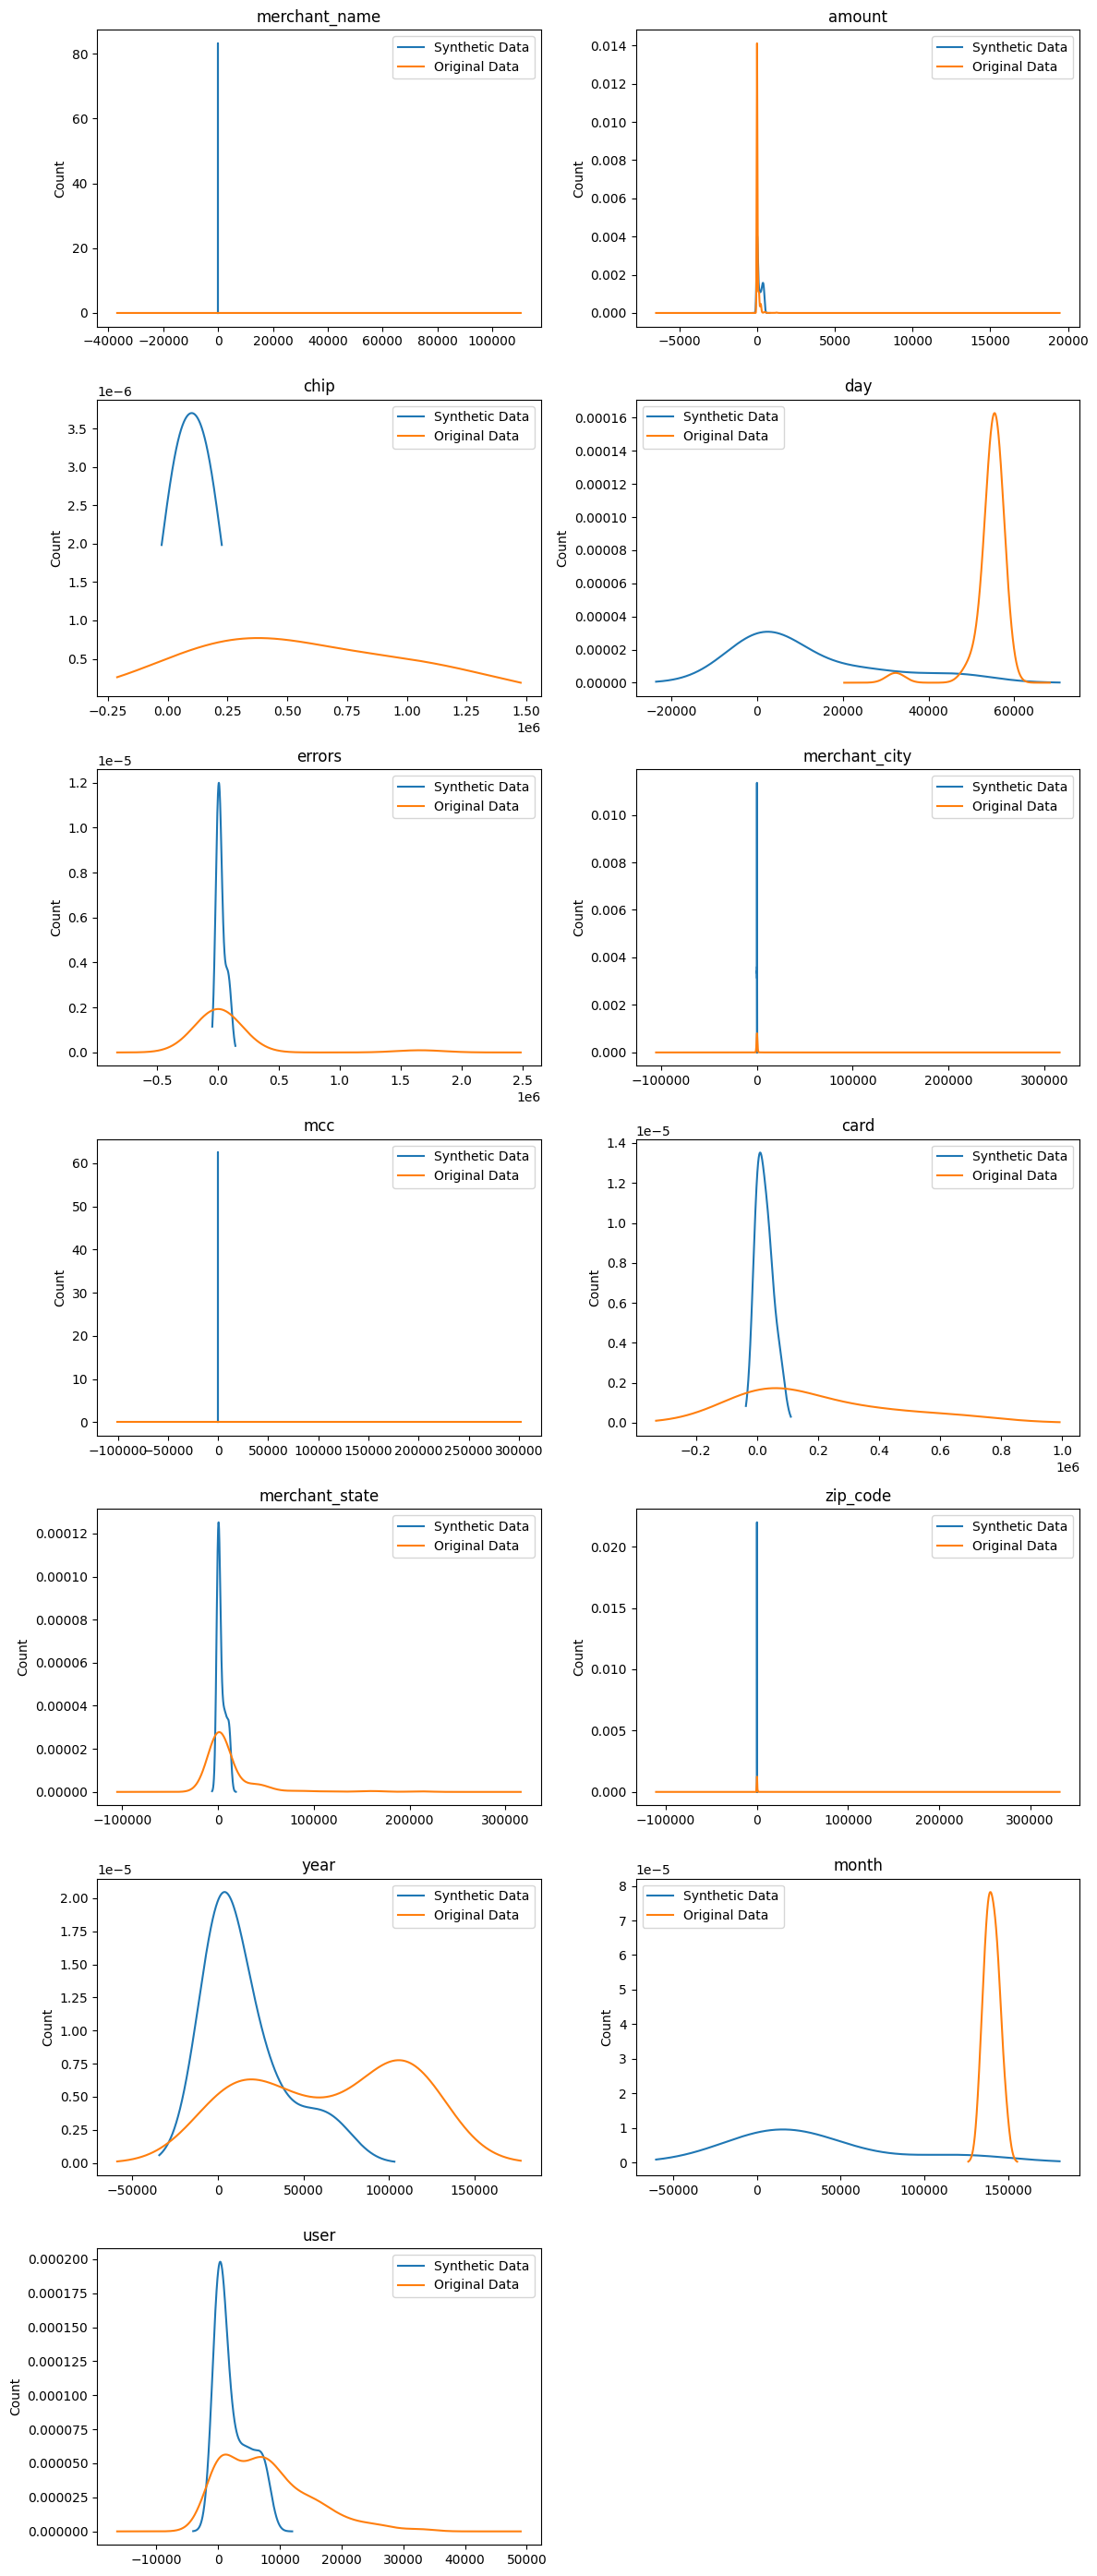

In [ ]:
# Define the number of columns and rows for the subplot grid
cat_cols = set(synthetic_data_non_fraud_final.columns)-set([ 'time'])
num_cols = 2
num_rows = (len(cat_cols) + 1) // num_cols + ((len(cat_cols) + 1) % num_cols > 0)

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

# Flatten the axes if there are more than one row
if num_rows > 1:
    axes = axes.flatten()

# Plot KDE for each categorical column
for i, col in enumerate(cat_cols):
    ax = axes[i]
    synthetic_data_non_fraud_final[col].value_counts().plot(kind='kde', ax=ax, label='Synthetic Data')
    original_data_non_fraud_final[col].value_counts().plot(kind='kde', ax=ax, label='Original Data')
    ax.set_title(col)
    ax.set_ylabel('Count')
    ax.legend()

# Remove unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and display plot
plt.tight_layout()
plt.show()
